In [ ]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


# `Imports`

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from collections import Counter
import glob

import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib

In [ ]:
from google.colab import files
import kagglehub

# Step 1: Upload kaggle.json manually
print("📂 Please upload your kaggle.json file:")
uploaded = files.upload()

# Ensure the uploaded file exists
if "kaggle.json" not in uploaded:
    print("❌ kaggle.json upload failed. Please try again.")
else:
    # Step 2: Move the file to the correct location
    !mkdir -p /root/.config/kaggle
    !mv kaggle.json /root/.config/kaggle/

    # Step 3: Set proper permissions (read and write)
    !chmod 600 /root/.config/kaggle/kaggle.json

    # Step 4: Verify that the file exists
    if os.path.exists("/root/.config/kaggle/kaggle.json"):
        print("✅ kaggle.json uploaded and set up correctly!")
    else:
        print("❌ kaggle.json upload failed. Please check the file path.")

# Step 5: download dataset
try:
    dataset_path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
    print("✅ Dataset downloaded successfully!")
    print("📂 Path to dataset files:", dataset_path)

    # Step 7: Move dataset to /content/{dataset-name} for easier access
    target_path = os.path.join(os.getcwd(), "garbage_dataset")
    !mkdir -p {target_path}  # Ensure target directory exists
    !cp -r {dataset_path}/* {target_path}/

    print(f"✅ Dataset moved to {target_path}")
    print("📂 Final Dataset contents:", os.listdir(target_path))

except Exception as e:
    print("❌ Error downloading dataset:", e)

📂 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ kaggle.json uploaded and set up correctly!


100%|██████████| 744M/744M [00:08<00:00, 95.9MB/s]

Extracting files...


✅ Dataset downloaded successfully!
📂 Path to dataset files: /root/.cache/kagglehub/datasets/sumn2u/garbage-classification-v2/versions/8
✅ Dataset moved to /content/garbage_dataset
📂 Final Dataset contents: ['garbage-dataset']


In [ ]:
source_dir = '/content/garbage_dataset/garbage-dataset'

In [ ]:
# Categories from your folder structure
categories = ['battery', 'biological', 'cardboard', 'clothes',
             'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']

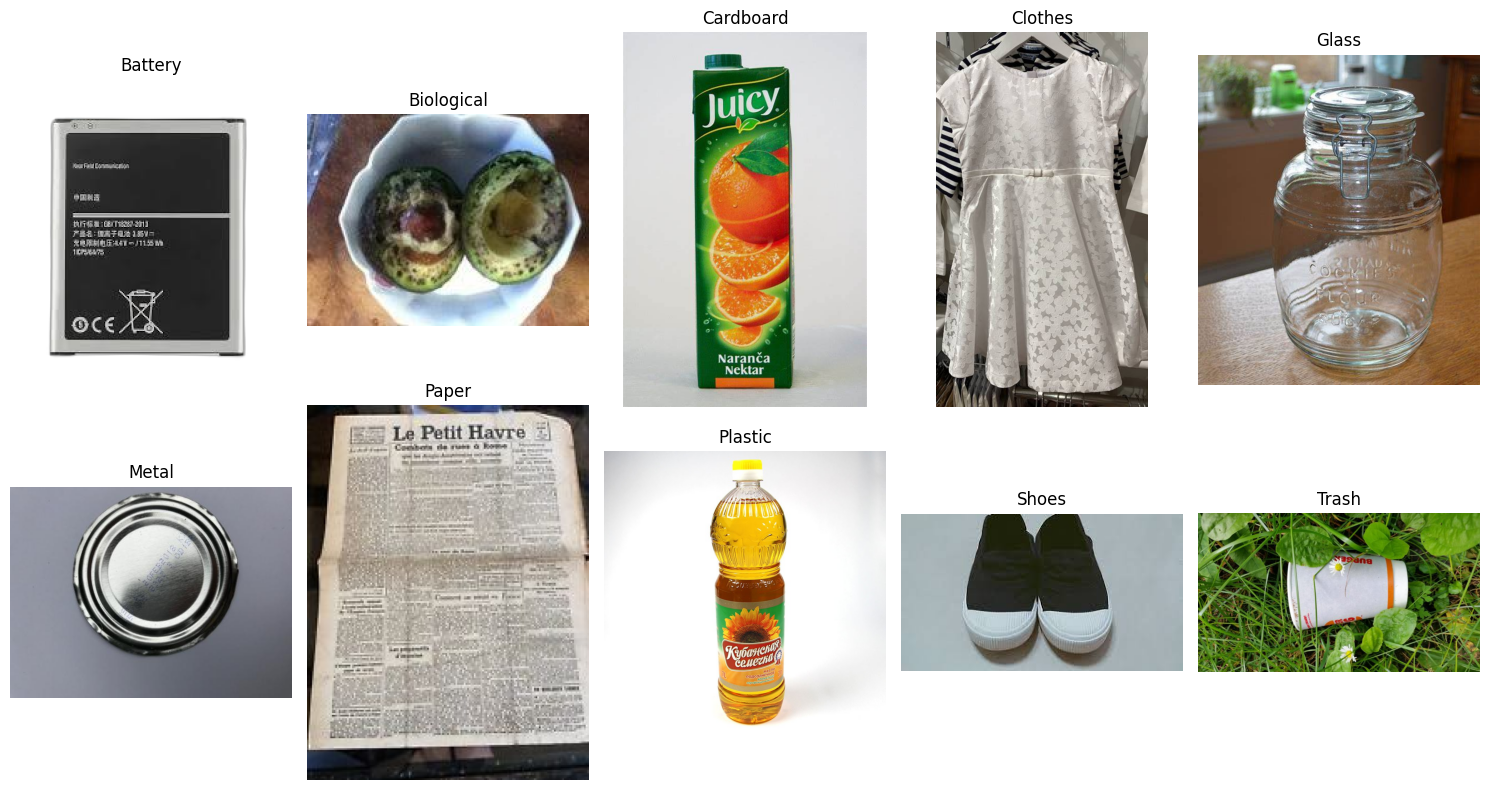

In [ ]:
# Create subplot grid
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, category in enumerate(categories):
    # create path of each category
    folder_path = f'{source_dir}/{category}'

    # List all images in the category
    images = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]

    if images:
        img_path = os.path.join(folder_path, random.choice(images))

        # Load and display
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(category.title())
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# `EDA`

In [ ]:
# dictionary for each category count
category_counts = {category: len(os.listdir(f'{source_dir}/{category}')) for category in categories}
category_counts

{'battery': 944,
 'biological': 997,
 'cardboard': 1825,
 'clothes': 5327,
 'glass': 3061,
 'metal': 1020,
 'paper': 1680,
 'plastic': 1984,
 'shoes': 1977,
 'trash': 947}

In [ ]:
# number of classes
len(categories)

10

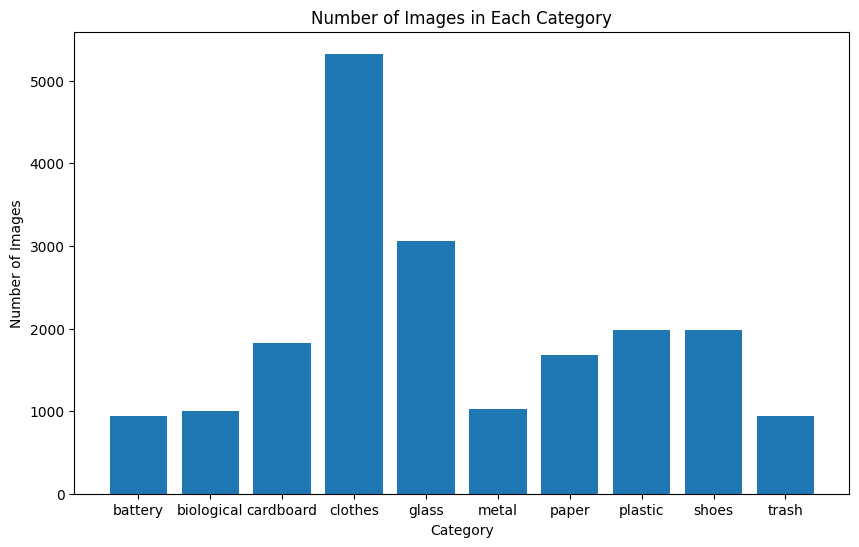

In [ ]:
# visualize
plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

- first issue: data imbalace
- all categories are closs in count except clothes

In [ ]:
# for each class invidually
'''
for category in categories:
    folder_path = f'/content/garbage_dataset/garbage-dataset/{category}'
    images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    size_counter = Counter()

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                size_counter[img.size] += 1  # img.size is (width, height)
        except Exception as e:
            print(f"Error reading {img_name}: {e}")

    print(f"\n📁 Category: {category}")
    for size, count in size_counter.items():
        print(f"Size {size}: {count} images")
'''

'\nfor category in categories:\n    folder_path = f\'/content/garbage_dataset/garbage-dataset/{category}\'\n    images = [f for f in os.listdir(folder_path) if f.endswith(\'.jpg\')]\n\n    size_counter = Counter()\n\n    for img_name in images:\n        img_path = os.path.join(folder_path, img_name)\n        try:\n            with Image.open(img_path) as img:\n                size_counter[img.size] += 1  # img.size is (width, height)\n        except Exception as e:\n            print(f"Error reading {img_name}: {e}")\n\n    print(f"\n📁 Category: {category}")\n    for size, count in size_counter.items():\n        print(f"Size {size}: {count} images")\n'

In [ ]:
# check on images size

# Initialize a global counter for all image sizes
global_size_counter = Counter()

for category in categories:
    folder_path = f'{source_dir}/{category}'
    images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    for img_name in images:
        img_path = os.path.join(folder_path, img_name)
        try:
            with Image.open(img_path) as img:
                global_size_counter[img.size] += 1  # img.size = (width, height)
        except Exception as e:
            print(f"Error reading {img_name} in {category}: {e}")

In [ ]:
# Sort by count in descending order
sorted_sizes = sorted(global_size_counter.items(), key=lambda x: x[1], reverse=True)

print("\n🧮 Image Size Count Across All Categories:")
for size, count in sorted_sizes:
    print(f"Size {size}: {count} images")


🧮 Image Size Count Across All Categories:
Size (400, 533): 2591 images
Size (512, 384): 2524 images
Size (225, 225): 1924 images
Size (400, 534): 1077 images
Size (275, 183): 671 images
Size (259, 194): 521 images
Size (533, 400): 387 images
Size (400, 711): 300 images
Size (474, 474): 240 images
Size (194, 259): 219 images
Size (474, 631): 186 images
Size (400, 400): 183 images
Size (534, 400): 163 images
Size (183, 275): 158 images
Size (800, 450): 154 images
Size (300, 168): 138 images
Size (474, 355): 129 images
Size (224, 224): 92 images
Size (169, 225): 88 images
Size (800, 600): 87 images
Size (711, 400): 86 images
Size (276, 183): 84 images
Size (265, 190): 60 images
Size (800, 800): 59 images
Size (260, 194): 52 images
Size (262, 192): 52 images
Size (264, 191): 51 images
Size (600, 600): 51 images
Size (252, 200): 46 images
Size (1000, 1000): 45 images
Size (475, 316): 45 images
Size (300, 300): 44 images
Size (1200, 1600): 44 images
Size (200, 200): 42 images
Size (400, 532

In [ ]:
# check on images size

# Initialize a global counter for all image sizes

sizes = []

for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    if os.path.isdir(folder_path):
        images = glob.glob(os.path.join(folder_path, '*.jpg'))
        for img_path in images:
            try:
                image = plt.imread(img_path)
                sizes.append(image.shape)  # shape = (height, width, channels)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")


In [ ]:
# Count and display the most common image sizes
size_counts = pd.Series(sizes).value_counts()
print(size_counts.head(10))

(533, 400, 3)    2591
(384, 512, 3)    2523
(225, 225, 3)    1799
(534, 400, 3)    1077
(183, 275, 3)     605
(194, 259, 3)     494
(400, 533, 3)     387
(711, 400, 3)     300
(474, 474, 3)     238
(259, 194, 3)     211
Name: count, dtype: int64


In [ ]:
# why first method is faster ??
import time

# Using plt.imread()
start = time.time()
plt.imread("/content/garbage_dataset/garbage-dataset/clothes/clothes_1.jpg").shape
print("matplotlib:", time.time() - start)

# Using PIL.Image.open().size
start = time.time()
Image.open("/content/garbage_dataset/garbage-dataset/clothes/clothes_1.jpg").size
print("PIL:", time.time() - start)


matplotlib: 0.002993345260620117
PIL: 0.00029158592224121094


- `PIL.Image.open().size`  is 30 times faster

In [ ]:
# check on pixel values for scaling later

pixel_min = []
pixel_max = []
pixel_mean = []

for folder in os.listdir(source_dir):
    folder_path = os.path.join(source_dir, folder)
    if os.path.isdir(folder_path):
        images = glob.glob(os.path.join(folder_path, '*.jpg'))
        if images:
            img_path = images[0]  # Take only the first image
            try:
                img = plt.imread(img_path).astype(np.float32)
                pixel_min.append(img.min())
                pixel_max.append(img.max())
                pixel_mean.append(img.mean())
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

# Summary
print("📊 Pixel Value Stats (One Image per Folder):")
print(f"Global Min: {np.min(pixel_min)}")
print(f"Global Max: {np.max(pixel_max)}")
print(f"Global Mean: {np.mean(pixel_mean):.2f}")

📊 Pixel Value Stats (One Image per Folder):
Global Min: 0.0
Global Max: 255.0
Global Mean: 165.84


In [ ]:
source_dir

'/content/garbage_dataset/garbage-dataset'

In [ ]:
### can use to stratify
'''
image_paths = []
labels = []

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    for img in os.listdir(class_path):
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_name)  # Same as your stratify logic
'''

'\nimage_paths = []\nlabels = []\n\nfor class_name in os.listdir(source_dir):\n    class_path = os.path.join(source_dir, class_name)\n    for img in os.listdir(class_path):\n        image_paths.append(os.path.join(class_path, img))\n        labels.append(class_name)  # Same as your stratify logic\n'

In [ ]:
# Split data to train, val, test

# Define source and target directories
base_dir = os.path.join(os.getcwd(), "garbage_splits")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create target directories
for dir_path in [train_dir, val_dir, test_dir]:
    os.makedirs(dir_path, exist_ok=True)

# Loop through each class folder and split images
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, testval_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(testval_imgs, test_size=0.5, random_state=42)

    for subset, subset_imgs in zip(["train", "val", "test"], [train_imgs, val_imgs, test_imgs]):
        target_class_dir = os.path.join(base_dir, subset, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        for img in subset_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(target_class_dir, img)
            shutil.copy2(src, dst)

print("✅ Dataset successfully split into train/val/test sets!")
print("📁 Train:", sum([len(files) for _, _, files in os.walk(train_dir)]))
print("📁 Val:", sum([len(files) for _, _, files in os.walk(val_dir)]))
print("📁 Test:", sum([len(files) for _, _, files in os.walk(test_dir)]))

✅ Dataset successfully split into train/val/test sets!
📁 Train: 15806
📁 Val: 1976
📁 Test: 1980


## `Preprocessing`

In [ ]:
target_size = (224, 224)     # can use 256 for more details, but slower

In [ ]:
# All images will only scaled with 1/255 (comman base for all splits)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# For Training
train_gen = datagen.flow_from_directory(directory=train_dir,
                                        target_size=target_size,
                                        batch_size=64,
                                        class_mode='categorical',   # "categorical" or "binary" or "sparse"
                                        color_mode='rgb',
                                        shuffle=True,
                                        seed=42)
# For Validation
val_gen = datagen.flow_from_directory(directory=val_dir,
                                        target_size=target_size,
                                        batch_size=32,
                                        class_mode='categorical',   # "categorical" or "binary" or "sparse"
                                        color_mode='rgb',
                                        shuffle=True,
                                        seed=42)

# For Testing
test_gen = datagen.flow_from_directory(directory=test_dir,
                                        target_size=target_size,
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=False)

Found 15806 images belonging to 10 classes.
Found 1976 images belonging to 10 classes.
Found 1980 images belonging to 10 classes.


## `Build the Model`

In [ ]:
shape=(target_size, 3)
shape
# unpack the tuple

((224, 224), 3)

## `Notes:`
## **as dataset is large -> use batch normalization**
# `why?`

1. BatchNorm helps in avoiding signal dying out:

- It normalizes activations to a standard range → avoids saturation.

- It keeps the gradient flow healthy → preventing vanishing or exploding.

- It centers and scales the input to each layer → making learning smoother.


2. Acts as regularization

3. Faster convergence

- we used it before activation

## **Why Drop out for FC**
- its rate ??

In [ ]:
model = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Input(shape=(*target_size, 3)),

    # Conv Base
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(4, 4)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Top Classifier
    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduces each feature map to a single number (its average).
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 512)      │             

 Total params: 1,854,538 (7.07 MB)

 Trainable params: 1,852,298 (7.07 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [ ]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# Early stopping
early_stopp = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

In [ ]:
model = load_model('my_model_checkpoint.keras')

In [ ]:
# Fitting
history = model.fit(train_gen,
                    validation_data=(val_gen),
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    epochs=20,
                    callbacks=[early_stopp])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 115s 376ms/step - accuracy: 0.8035 - loss: 0.5949 - val_accuracy: 0.7363 - val_loss: 0.7956
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 98s 279ms/step - accuracy: 0.8000 - loss: 0.6021 - val_accuracy: 0.6528 - val_loss: 1.1191
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 67s 271ms/step - accuracy: 0.7958 - loss: 0.6099 - val_accuracy: 0.6847 - val_loss: 0.9453
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - accuracy: 0.8057 - loss: 0.5911 - val_accuracy: 0.7743 - val_loss: 0.6930
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 66s 268ms/step - accuracy: 0.8142 - loss: 0.5713 - val_accuracy: 0.7115 - val_loss: 0.8852
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 66s 268ms/step - accuracy: 0.8200 - loss: 0.5469 - val_accuracy: 0.7677 - val_loss: 0.7483
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 67s 271ms/step - accuracy: 0.8272 - loss: 0.5401 - val_accuracy: 0.7373 - val_loss: 0.7994
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 87s 291ms/step - accuracy: 0.8183 - loss: 

In [ ]:
model.save('my_model_checkpoint2.keras')

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
model = tf.keras.models.Sequential([
    # Input Layer
    tf.keras.layers.Input(shape=(*target_size, 3)),

    # Conv Base
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),

    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Top Classifier
    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(),  # Reduces each feature map to a single number (its average).
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.4),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# Compile
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

# Early stopping
early_stopp = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)

# learning rate scheduler
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
model = load_model('my_model_checkpoint2.keras')

In [ ]:
# Fitting
history = model.fit(train_gen,
                    validation_data=(val_gen),
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    epochs=20,
                    callbacks=[early_stopp, lr_schedule])

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 85s 317ms/step - accuracy: 0.8202 - loss: 0.5514 - val_accuracy: 0.7682 - val_loss: 0.6954 - learning_rate: 1.0000e-04
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 67s 271ms/step - accuracy: 0.8187 - loss: 0.5491 - val_accuracy: 0.7551 - val_loss: 0.7695 - learning_rate: 1.0000e-04
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 83s 275ms/step - accuracy: 0.8231 - loss: 0.5416 - val_accuracy: 0.7586 - val_loss: 0.7251 - learning_rate: 1.0000e-04
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8258 - loss: 0.5322
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
247/247 ━━━━━━━━━━━━━━━━━━━━ 67s 272ms/step - accuracy: 0.8258 - loss: 0.5323 - val_accuracy: 0.7530 - val_loss: 0.8106 - learning_rate: 1.0000e-04
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 67s 270ms/step - accuracy: 0.8461 - loss: 0.4780 - val_accuracy: 0.7880 - val_loss: 0.6594 - learning_rate: 5.0000e-05
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 68s 276ms/st

In [ ]:
model.save('my_model.keras')

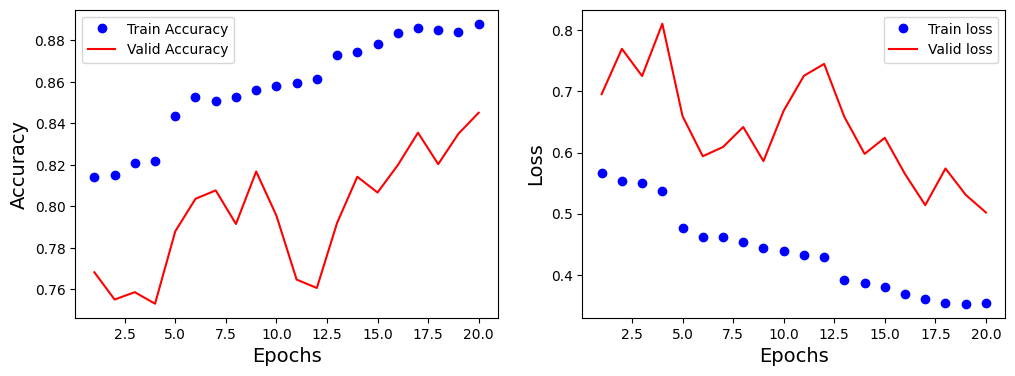

In [ ]:
# Visualize the resutls
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy',  fontsize=14)
plt.legend()

plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss',  fontsize=14)
plt.legend()
plt.show()

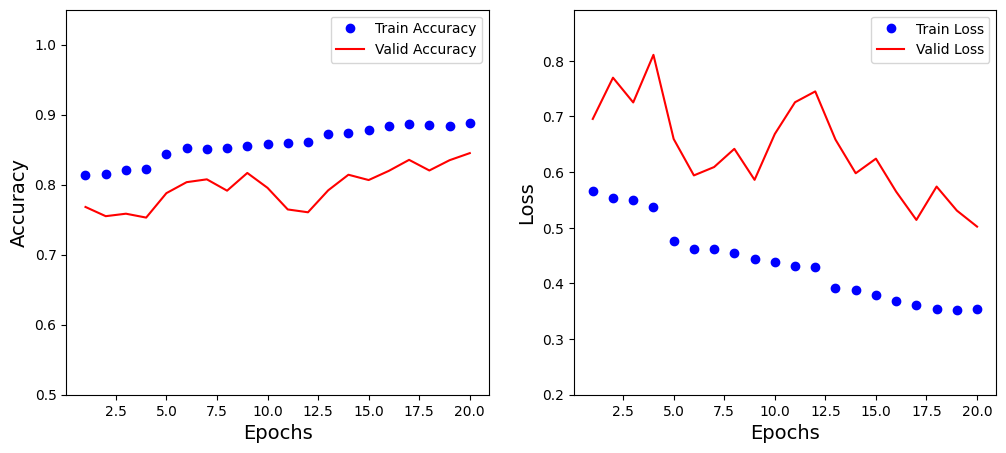

In [ ]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
n_epochs = len(history.history['loss'])  # real number of epochs in history, as we made early stopp

# Accuracy Plot
plt.sca(ax[0])
plt.plot(range(1, n_epochs+1), history.history['accuracy'], 'bo', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), history.history['val_accuracy'], 'r-', label='Valid Accuracy')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.5, 1.05)  # Set Y-axis range for accuracy
plt.legend()

# Loss Plot
plt.sca(ax[1])
plt.plot(range(1, n_epochs+1), history.history['loss'], 'bo', label='Train Loss')
plt.plot(range(1, n_epochs+1), history.history['val_loss'], 'r-', label='Valid Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.ylim(0.2, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)  # dynamic limit with buffer
plt.legend()

plt.show()


In [ ]:
# Evaluate on test set
loss_test, acc_test = model.evaluate(test_gen, verbose=0)
print(f"Test Loss:  {loss_test:.4f}")
print(f"Test Acc:   {acc_test:.4f}")

# Retrieve last epoch metrics from training history
loss_train = history.history['loss'][-1]
acc_train = history.history['accuracy'][-1]
loss_val = history.history['val_loss'][-1]
acc_val = history.history['val_accuracy'][-1]

# Print all together for comparison
print("\n--- Final Epoch Comparison ---")
print(f"Train Loss: {loss_train:.4f} | Accuracy: {acc_train:.4f}")
print(f"Val   Loss: {loss_val:.4f} | Accuracy: {acc_val:.4f}")
print(f"Test  Loss: {loss_test:.4f} | Accuracy: {acc_test:.4f}")


Test Loss:  0.5175
Test Acc:   0.8419

--- Final Epoch Comparison ---
Train Loss: 0.3533 | Accuracy: 0.8881
Val   Loss: 0.5020 | Accuracy: 0.8451
Test  Loss: 0.5175 | Accuracy: 0.8419


## Augmentation

In [ ]:
''' # Augmented Data Generator for Training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Clean Generator for Validation and Testing
test_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Training Generator with Augmentation
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# Validation Generator (NO augmentation)
val_gen = test_val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

# Test Generator (NO augmentation)
test_gen = test_val_datagen.flow_from_directory(
    directory=test_dir,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
 '''

Found 15806 images belonging to 10 classes.
Found 1976 images belonging to 10 classes.
Found 1980 images belonging to 10 classes.


- reached 89/84 accuracy without agumentation
- can try and continue on my_model.keras

# `Transfer Learning`

In [ ]:
target_size = (224, 224)

In [ ]:
# All images will only scaled with 1/255 (comman base for all splits)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# For Training
train_gen = datagen.flow_from_directory(directory=train_dir,
                                        target_size=target_size,
                                        batch_size=64,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        seed=42)
# For Validation
val_gen = datagen.flow_from_directory(directory=val_dir,
                                        target_size=target_size,
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        seed=42)

# For Testing
test_gen = datagen.flow_from_directory(directory=test_dir,
                                        target_size=target_size,
                                        batch_size=32,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=False)

Found 15806 images belonging to 10 classes.
Found 1976 images belonging to 10 classes.
Found 1980 images belonging to 10 classes.


In [ ]:
# Get class indices from train_gen
class_indices = train_gen.class_indices  # {'battery': 0, 'biological': 1, ..., 'trash': 9}
class_labels = list(class_indices.values())  # [0, 1, ..., 9]

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=train_gen.classes  # Array of labels for all training images
)

# Convert to dictionary
class_weights = dict(enumerate(class_weights_array))  # pass later as a parameter in fit

In [ ]:
# Load EfficientNetB4 and use it as a ConvBase
conv_base = tf.keras.applications.EfficientNetB4(
    include_top=False,              # exclude the FC layers
    weights='imagenet',             # use pretrained ImageNet weights
    input_shape=(*target_size, 3),  # Required input size for EfficientNetB4
    pooling='avg'                   # GlobalAveragePooling2D after conv layers, defult is null
)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze the base model (only as a feature extractor)
conv_base.trainable = False

In [ ]:
conv_base.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
# FC for Multi-Layer CLF
top_clf = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
top_clf.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493,194 (1.88 MB)

 Trainable params: 493,194 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define full model
model = tf.keras.Sequential([
    conv_base,
    top_clf
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │       493,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,167,017 (69.30 MB)

 Trainable params: 493,194 (1.88 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

- most of them are untrainable because we freezed conv_base

In [ ]:
# ===== Compile Model =====
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
# ===== Callbacks =====

# 1. Early Stopping - stop training if val loss doesn't improve
early_stopp = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# 2. Model Checkpoint - save the best model during training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',              # save in modern format
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 3. ReduceLROnPlateau - lower learning rate if stuck
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,           # reduce by this factor
    patience=3,
    min_lr=1e-6,
    verbose=1
)

##`Train`

In [ ]:
# Fitting
history = model.fit(train_gen,
                    validation_data=(val_gen),
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    epochs=20,
                    callbacks=[early_stopp, checkpoint, reduce_lr],
                    class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4873 - loss: 1.7562
Epoch 1: val_loss improved from inf to 0.43989, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 164s 468ms/step - accuracy: 0.4881 - loss: 1.7543 - val_accuracy: 0.8866 - val_loss: 0.4399 - learning_rate: 1.0000e-04
Epoch 2/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8656 - loss: 0.5387
Epoch 2: val_loss improved from 0.43989 to 0.30886, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 127s 277ms/step - accuracy: 0.8656 - loss: 0.5385 - val_accuracy: 0.9114 - val_loss: 0.3089 - learning_rate: 1.0000e-04
Epoch 3/10
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8936 - loss: 0.3957
Epoch 3: val_loss improved from 0.30886 to 0.26706, saving model to best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 81s 275ms/step - accuracy: 0.8936 - loss: 0.3957 - val_accuracy: 0.9266 - val_loss: 0.2671 - learning_rate: 1.0000e-04
Epoch 4/10
247/247 ━━━━━━━━━━━━━━━━━━━━